In [2]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.rdmolfiles import MolFragmentToSmiles
from rdkit.Chem.PandasTools import AddMoleculeColumnToFrame
from IPython.display import HTML
IPythonConsole.molSize = (600,300)
IPythonConsole.drawOptions.addAtomIndices = True

def show_df(df):
    return HTML(df.to_html(notebook=True))

In [3]:
def get_ring_systems(mol, includeSpiro=False):
    """
    Retrieve atom indices grouped into ring systems within a given molecule.
    
    Args:
        mol (rdkit.Chem.Mol): RDKit molecule object representing the molecular structure.
        includeSpiro (bool, optional): If True, include spiro-connected atoms in the ring systems. 
            Defaults to False.

    Returns:
        list of set: A list of sets, where each set contains the indices of atoms belonging to a ring system.
    """
    ri = mol.GetRingInfo()
    systems = []

    # Scaping
    if len(ri.AtomRings()) == 0:
        return [0] # Return a carbon
    
    for ring in ri.AtomRings():
        ringAts = set(ring)
        nSystems = []
        for system in systems:
            nInCommon = len(ringAts.intersection(system))

            if nInCommon and (includeSpiro or nInCommon>1):
                ringAts = ringAts.union(system)
            else:
                nSystems.append(system)
        nSystems.append(ringAts)
        systems = nSystems
    return systems

def get_ring_adjacent(mol):
    """
    Retrieve atom indices within ring systems along with their adjacent atoms. This functions have the get_ring_systems() as a dependency;

    Args:
        mol (rdkit.Chem.Mol): RDKit molecule object representing the molecular structure.

    Returns:
        list of set: A list of sets, where each set contains the indices of atoms in a ring system 
        along with their adjacent atoms.
    """
    ring_systems = get_ring_systems(mol, includeSpiro=False)

    rings = []
    for ring in ring_systems:
        ring_with_adjacent = set(ring)
        for ring_atom in ring:
            neighbors = set(mol.GetAtomWithIdx(ring_atom).GetNeighbors())
            
            for neighbor_atom in neighbors:
                if (neighbor_atom.GetIdx() not in ring) and (neighbor_atom.GetIsAromatic()):
                    neighbor_atom.SetIsAromatic(False)
                    ring_with_adjacent.add(neighbor_atom.GetIdx())
                else:
                    ring_with_adjacent.add(neighbor_atom.GetIdx())
        rings.append(ring_with_adjacent)

    return rings

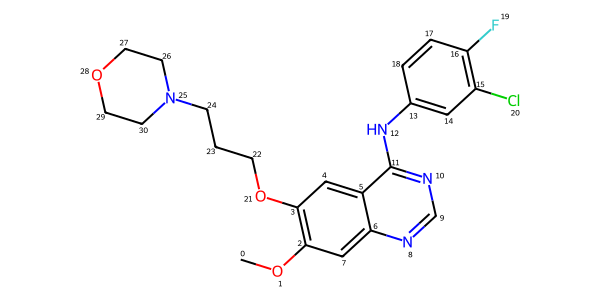

In [4]:
gefitinib = Chem.MolFromSmiles('COC1=C(C=C2C(=C1)N=CN=C2NC3=CC(=C(C=C3)F)Cl)OCCCN4CCOCC4')
gefitinib

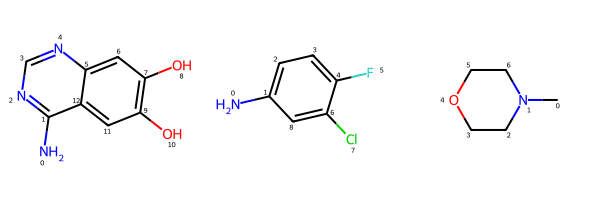

In [5]:
rings = get_ring_adjacent(gefitinib)
mols = []
for ring in rings:
    mol = Chem.MolFromSmiles(MolFragmentToSmiles(gefitinib, atomsToUse=ring))
    mols.append(mol)
Draw.MolsToGridImage(mols)

In [1]:
# Design of the steps
# Loading the data

# Creating an list of SMILES from the data

# Create an empty list for storing the data as a list of dicts
# total_dict = []
    ## Loop through this list to generate a MOL object from SMILES
        ### Escape structures that have no Ring using get_ring_systems()
        ### If molecue has ring, then get every ring and the adjacent atoms
        ### Append new info, keeping the parent SMILES stored total_dict.append{[parent_smiles] = [fragment_smiles]}
# end

In [32]:
# Data
fda_drugs_df = pd.read_csv('../../data/fda_approved_datasets/pre_cleaned_datasets/pre_cleaned_unique.csv')
list_of_smiles = fda_drugs_df['clean_smiles'].to_list()
# chembl_id
# To search through the SMILES
chembl_ids = fda_drugs_df[['clean_smiles', 'chembl_id']]

# Empty list
parents_and_fragments = []
no_rings = []

for smiles in list_of_smiles:
    mol = Chem.MolFromSmiles(smiles)
    if get_ring_systems(mol) == [0]:
        no_rings.append(smiles)
    else:
        rings = get_ring_adjacent(mol)
        for ring in rings:
            ring_fragment = Chem.MolFragmentToSmiles(mol, atomsToUse=ring)
            parent_smiles = Chem.MolToSmiles(mol)
            chembl_id = chembl_ids[chembl_ids['clean_smiles'] == parent_smiles].chembl_id
            parents_and_fragments.append({parent_smiles: [ring_fragment, chembl_id]})

# Transforming it into pd.DataFrame (wide-format)
ring_fragments_df = pd.DataFrame.from_dict(parents_and_fragments)

In [34]:
ring_fragments_df = ring_fragments_df.stack()

In [7]:
ring_fragments_df = ring_fragments_df.stack()
ring_fragments_df = ring_fragments_df.reset_index()
ring_fragments_df.rename(columns={'level_0':'index', 'level_1':'parent', 0:'fragment'}, inplace=True)
ring_fragments_df.drop(columns=['index'], inplace=True)
ring_fragments_df.head(12)

,parent,fragment
0,Cc1cn[nH]c1,Cc1cn[nH]c1
1,C1CNCCN1,C1CNCCN1
2,Nc1ccncc1,Nc1ccncc1
3,N[C@@H]1CONC1=O,N[C@@H]1CONC1=O
4,Nc1ccncc1N,Nc1ccncc1N
5,Oc1cccc(O)c1,Oc1cccc(O)c1
6,NCCc1cc[nH]n1,Cc1cc[nH]n1
7,NCCc1c[nH]cn1,Cc1c[nH]cn1
8,Cn1ccnc1S,Cn1ccnc1S
9,NC(=O)c1cnccn1,Cc1cnccn1


In [ ]:
ring_fragments_df.to_csv('../../data/fragments/fda_approved_rf.csv', index=False)